In [4]:
    
from math import sqrt
quad_points = [-1/sqrt(3), 1/sqrt(3)]
quad_weights = [1,1]

[-0.00581188  0.01162377  0.01873008  0.02646666  0.0309492   0.03259174
  0.0309492   0.02646666  0.01873008  0.01162377 -0.00581188]
m [[ 3.46410162e+01 -9.28203230e+00  2.48711306e+00 -6.66419942e-01
   1.78566708e-01 -4.78468900e-02  1.28208517e-02 -3.43651696e-03
   9.25216104e-04 -2.64347458e-04  1.32173729e-04]
 [-9.28203230e+00  1.85640646e+01 -4.97422612e+00  1.33283988e+00
  -3.57133416e-01  9.56937799e-02 -2.56417035e-02  6.87303392e-03
  -1.85043221e-03  5.28694917e-04 -2.64347458e-04]
 [ 2.48711306e+00 -4.97422612e+00  1.74097914e+01 -4.66493960e+00
   1.24996696e+00 -3.34928230e-01  8.97459621e-02 -2.40556187e-02
   6.47651273e-03 -1.85043221e-03  9.25216104e-04]
 [-6.66419942e-01  1.33283988e+00 -4.66493960e+00  1.73269185e+01
  -4.64273441e+00  1.24401914e+00 -3.33342145e-01  8.93494409e-02
  -2.40556187e-02  6.87303392e-03 -3.43651696e-03]
 [ 1.78566708e-01 -3.57133416e-01  1.24996696e+00 -4.64273441e+00
   1.73209707e+01 -4.64114833e+00  1.24362262e+00 -3.33342145e-01

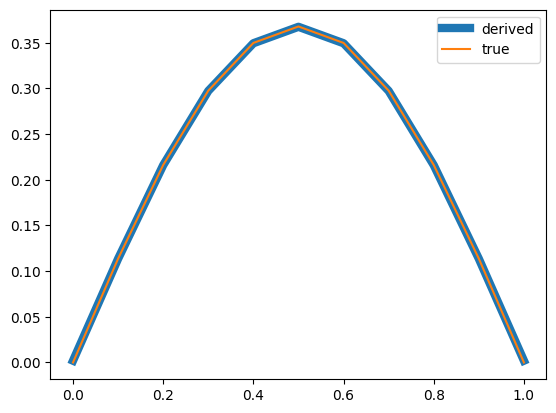

In [7]:
import numpy as np
from matplotlib import pyplot as plt


def f(x, t):
    return (np.pi**2 - 1) * np.exp(-t) * np.sin(np.pi * x)

def K_M(N, h):
    Ne = N - 1
    K = np.zeros((N, N))
    M = np.zeros((N, N))

    for k in range(Ne):
        mlocal = np.zeros((2, 2))
        klocal = np.zeros((2, 2))

        for l in range(2):
            for m in range(2):
                klocal[l, m] = -1 / h if l != m else 1 / h
                mlocal[l, m] = h / 6 if l != m else h / 3
        for l in range(2):
            globalnode1 = k + l
            for m in range(2):
                globalnode2 = k + m
                K[globalnode1, globalnode2] += klocal[l, m]
                M[globalnode1, globalnode2] += mlocal[l, m]

    return K, M

def apply_dirichlet_bc(K, F, u_db, dirichlet_nodes):
    """Apply Dirichlet boundary conditions to the stiffness matrix and force vector."""
    for i in dirichlet_nodes:
        for j in range(K.shape[0]):
            if i != j:
                F[j] -= K[j, i] * u_db[i]
                K[j, i] = 0  # Set column to zero
                K[i, j] = 0  # Set row to zero
        K[i, i] = 1
        F[i] = u_db[i]
    return K, F
def u_boundary(x):
    return np.sin(np.pi * x)


N = 11
xi = np.linspace(0, 1, N)
h = xi[1] - xi[0]

dt = 1 / 580
tf = 1
t0 = 0
nt = int((tf - t0) / dt)
ctime = t0

K, M = K_M(N, h)

M_inv = np.linalg.inv(M)
dx_de = h / 2

phi = lambda eta: [(1 - eta) / 2, (1 + eta) / 2]
q1 = -1 / sqrt(3)
q2 = 1 / sqrt(3)

u = np.zeros(( N,nt + 1))  # Time-dependent solution array
u[:, 0] = u_boundary(xi)

# Set Dirichlet boundary conditions
u_db = np.zeros(N)  # Prescribed values (e.g., zero at boundaries)
dirichlet_nodes = [0, N - 1]  # Dirichlet nodes at boundaries

for n in range(nt):
    ctime = t0 + n * dt
    F = np.zeros(N)
    for k in range(N - 1):
        flocal = np.zeros(2)
        for l in range(2):
            for p in range(len(quad_points)):
                # flocal[l] += f((h/2) * (quad_points[p] + 1) + xi[k], ctime) * quad_weights[p] * (h / 2)
                flocal[l] += f((h / 2) * (quad_points[p] + 1) + xi[k], ctime) * quad_weights[p] * (h / 2) * phi(quad_points[p])[l] ## phi??


        for l in range(2):
            globalnode = k + l
            F[globalnode] += flocal[l]
        

    # Apply Dirichlet boundary conditions to K and F
    K_bc, F_bc = apply_dirichlet_bc(K.copy(), F.copy(), u_db, dirichlet_nodes)

    # Time-stepping method (Forward Euler here)
    method = 'FE'
    if method == 'FE':
        # F_bc = np.zeros(N)
        u[:,n + 1] = u[:,n] - dt * M_inv @ K_bc @ u[:,n] + dt * M_inv @ F_bc
        print(dt * M_inv @ K_bc @ u[:,n] + dt * M_inv @ F_bc)
        print("m", M_inv)
    print(n/nt)

plt.plot(xi,u[:,-1], label = "derived", linewidth =6)
plt.plot(xi, np.sin(np.pi * xi)*np.exp(-1), label = "true")
print("a",np.max(f(xi,1)) - np.max(u[:,int(len(xi)/2)]))
plt.legend()
plt.show()


0.0
0.3333333333333333
0.6666666666666666
Error at midpoint: 2.8878202943786997


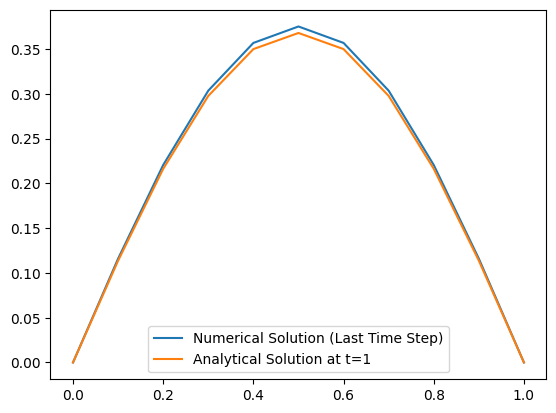

0.0
0.3333333333333333
0.6666666666666666
Error at midpoint: 2.8878202943786997


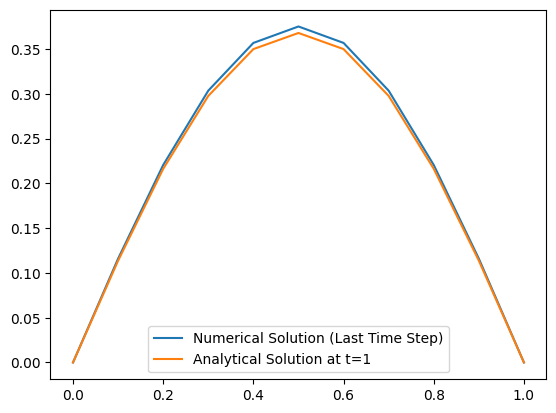

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt

def f(x, t):
    return (np.pi**2 - 1) * np.exp(-t) * np.sin(np.pi * x)

def K_M(N, h):
    Ne = N - 1
    K = np.zeros((N, N))
    M = np.zeros((N, N))

    for k in range(Ne):
        mlocal = np.zeros((2, 2))
        klocal = np.zeros((2, 2))
        for l in range(2):
            for m in range(2):
                klocal[l, m] = -1 / h if l != m else 1 / h
                mlocal[l, m] = h / 6 if l != m else h / 3
        for l in range(2):
            globalnode1 = k + l
            for m in range(2):
                globalnode2 = k + m
                K[globalnode1, globalnode2] += klocal[l, m]
                M[globalnode1, globalnode2] += mlocal[l, m]

    return K, M

def apply_dirichlet_bc(K, F, u_db, dirichlet_nodes):
    for i in dirichlet_nodes:
        for j in range(K.shape[0]):
            if i != j:
                F[j] -= K[j, i] * u_db[i]
                K[j, i] = 0
                K[i, j] = 0
        K[i, i] = 1
        F[i] = u_db[i]
    return K, F

def u_boundary(x):
    return np.sin(np.pi * x)

def main():
    N = 11
    xi = np.linspace(0, 1, N)
    h = xi[1] - xi[0]

    dt = 1/3
    tf = 1
    t0 = 0
    nt = int((tf - t0) / dt)
    ctime = t0

    K, M = K_M(N, h)

    dx_de = h / 2

    phi = lambda eta: [(1 - eta) / 2, (1 + eta) / 2]
    quad_points = [-1 / sqrt(3), 1 / sqrt(3)]  # 2-point Gaussian quadrature
    quad_weights = [1, 1]  # Equal weights for 2-point quadrature

    u = np.zeros((N, nt + 1))  
    u[:, 0] = u_boundary(xi)
    
    u_db = np.zeros(N)  
    dirichlet_nodes = [0, N - 1]  

    method = 'BE'  

    for n in range(nt):
        print(n/nt)
        ctime = t0 + n * dt
        F = np.zeros(N)
        for k in range(N - 1):
            flocal = np.zeros(2)
            for l in range(2):
                for p in range(len(quad_points)):
                    flocal[l] += (
                        f((h/2) * (quad_points[p] + 1) + xi[k], ctime + dt)
                        * quad_weights[p]
                        * (h/2)
                        * phi(quad_points[p])[l]
                    )
            for l in range(2):
                globalnode = k + l
                F[globalnode] += flocal[l]

        if method == 'BE':
            A = M + dt * K  # System matrix
            b = M @ u[:, n] + dt * F  # Right-hand side vector
            
            # Apply Dirichlet boundary conditions to A and b
            A_bc, b_bc = apply_dirichlet_bc(A.copy(), b.copy(), u_db, dirichlet_nodes)

            # Solve for the next timestep
            u[:, n + 1] = np.linalg.solve(A_bc, b_bc)

    print("Error at midpoint:", np.max(f(0.5, 1)) - np.max(u[int(len(xi) / 2), -1]))
    plt.plot(xi, u[:, -1], label="Numerical Solution (Last Time Step)")
    plt.plot(xi, f(xi, tf) / (np.pi**2 - 1), label="Analytical Solution at t=1")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


if __name__ == "__main__":
    main()
